# import library

In [1]:
import os
import mmcv
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.io as io
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from glob import glob
from mmcv.ops import nms
from ipywidgets import interact
from mmcv import Config, DictAction
from mmdet.datasets import build_dataset
from matplotlib.ticker import MultipleLocator
from mmdet.core.evaluation.bbox_overlaps import bbox_overlaps
import matplotlib.gridspec as gridspec


# GT, Predict wrong, right 시각화

In [264]:

config_path = '/opt/ml/detection/baseline/mmdetection/work_dirs/cascade_rcnn_swinL224_fpn_f16_ms_OHEM_cb_mining_load/cascade_rcnn_swinL224_fpn_f16_ms_OHEM_cb_mining.py'
# '/opt/ml/detection/baseline/mmdetection/configs/my_model/faster_rcnn_r50_fpn_1x_coco_custom.py'

prediction_path = '/opt/ml/detection/baseline/mmdetection/work_dirs/cascade_rcnn_swinL224_fpn_f16_ms_OHEM_cb_mining_load/result_softnms_0.5.pkl'
# '/opt/ml/detection/baseline/mmdetection/work_dirs/test/result.pkl'

# default_setting
color_theme='plasma'
score_thr = 0.3
tp_iou_thr = 0.5
nms_iou_thr = None
palette = sns.color_palette('bright')
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

In [265]:
cfg = Config.fromfile(config_path)

results = mmcv.load(prediction_path)
assert isinstance(results, list)
if isinstance(results[0], list):
    pass
elif isinstance(results[0], tuple):
    results = [result[0] for result in results]
else:
    raise TypeError('invalid type of prediction results')

if isinstance(cfg.data.test, dict):
    cfg.data.test.test_mode = True
elif isinstance(cfg.data.test, list):
    for ds_cfg in cfg.data.test:
        ds_cfg.test_mode = True
# 테스트하고 싶으면 cfg.data.test 넣기
dataset = build_dataset(cfg.data.val)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# class별 Precision, Recall 구하기

In [247]:
iou_thr = 0.5
score_thr = 0
save_dir = '/opt/ml/detection/baseline/mmdetection/work_dirs/cascade_rcnn_swinL224_fpn_f16_ms_OHEM_cb_mining_load'
save_fname = 'iou_thr_' + str(iou_thr) + '_score_thr_' + str(score_thr) + 'soft_nms0.45'+'.csv'

recall_per_cls = np.zeros((10,))
precision_per_cls = np.zeros((10,))
num_img_per_cls = np.zeros((10,))

for img_idx, result in enumerate(results):
    ann = dataset.get_ann_info(img_idx)
    gt_bboxes = ann['bboxes']
    gt_labels = ann['labels']
    for cls_id, predict in enumerate(result):
        if cls_id in gt_labels:
            # 해당 class의 gt가 존재하는 경우

            gt_idx = np.where(gt_labels==cls_id)[0]
            predict = predict[predict[:, 4]>=score_thr]

            if(len(predict)>0):
                # 만약 해당 클래스를 예측한 bbox가 존재할 시
                ious = bbox_overlaps(predict[:, :4], gt_bboxes[gt_idx])

                (found_det, found_gt)=np.where(ious[:]>=iou_thr)
                # iou thr 이상의 iou만 TP로 지정

                precision = len(set(found_det)) / len(ious)
                recall = len(set(found_gt)) / len(gt_idx)
            else:
                # 만약 해당 클래스를 예측한 bbox가 없을 시 
                precision = 0
                recall = 0
            
            recall_per_cls[cls_id]+=recall
            precision_per_cls[cls_id]+=precision
            # 해당 클래스의 gt가 존재할 때만 precision, recall 계산
            num_img_per_cls[cls_id]+=1

average_recall = recall_per_cls/num_img_per_cls
average_precision = precision_per_cls/num_img_per_cls
PR_df = pd.DataFrame([x for x in zip(average_precision, average_recall)], columns=['average_precision', 'average_recall'],index=["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"] )

PR_df.to_csv(os.path.join(save_dir, save_fname), sep='\t')

# class별 TP의 score 분포
### 클래스를 얼마나 구별을 잘하는지 알아보기 위한 분석
### 이 분포를 통해 class별로 다르게 score threshold를 줄 수도 있을 것 같다. 

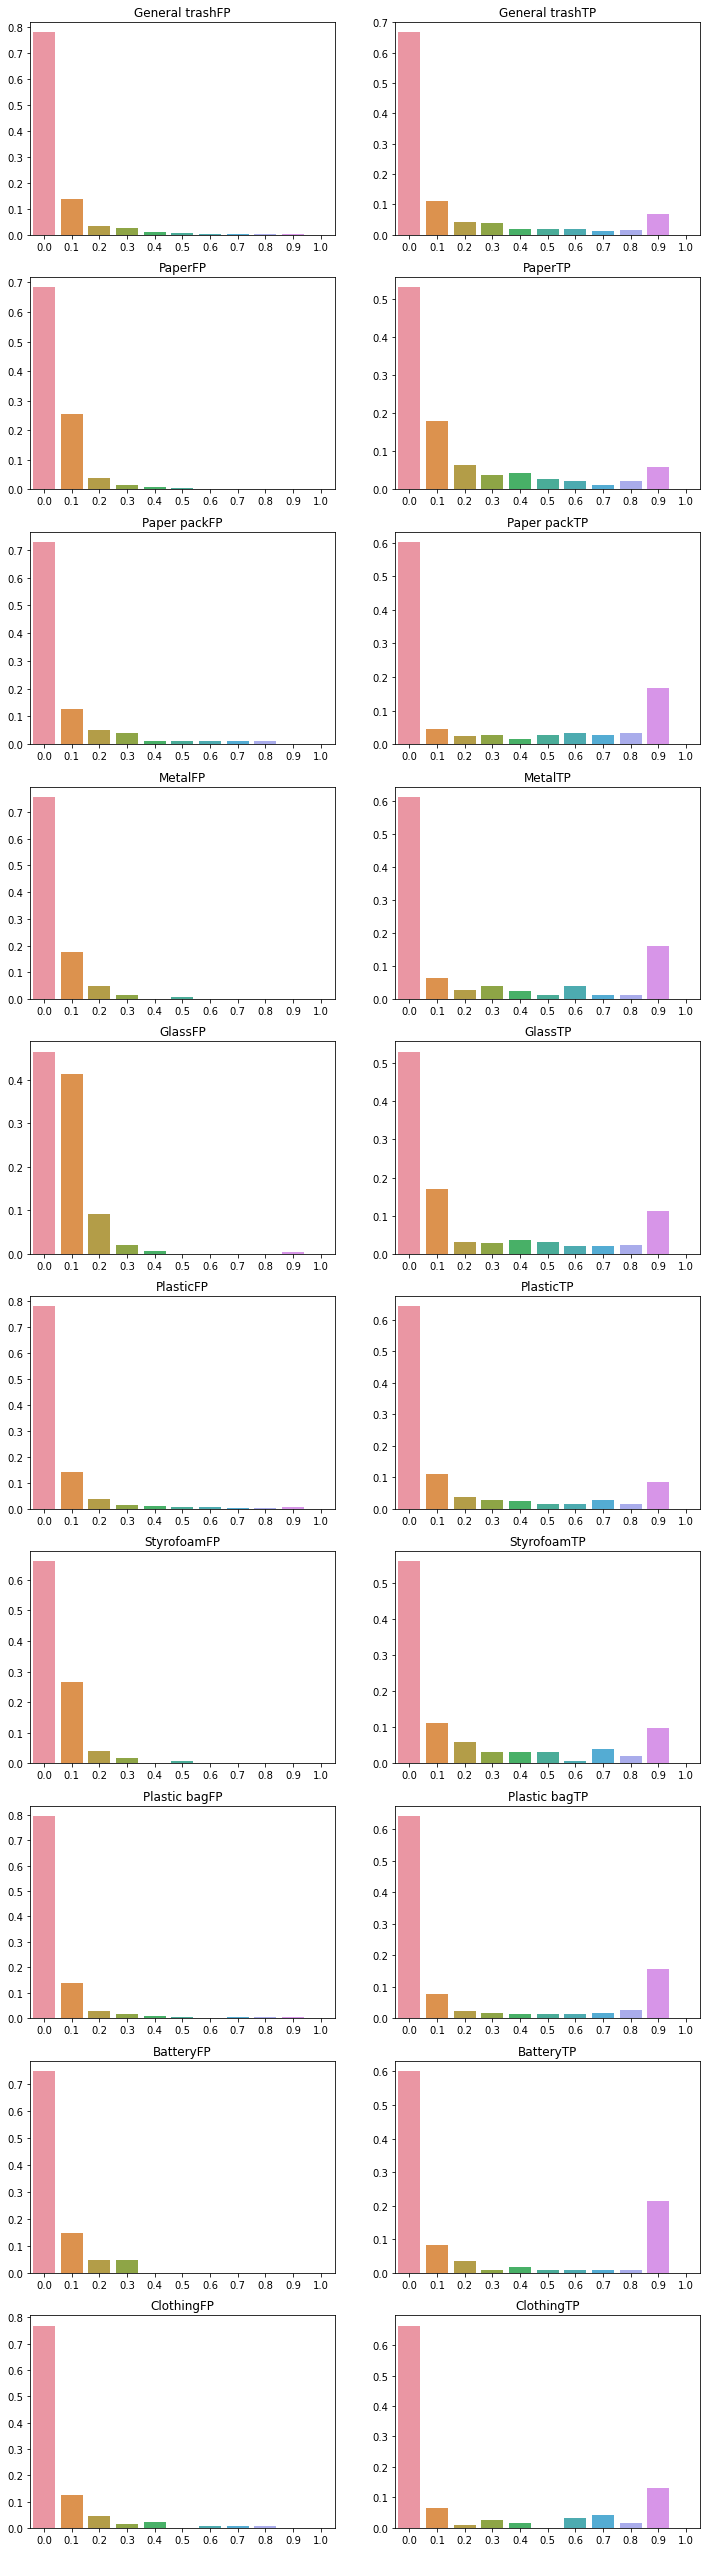

In [266]:
class_name = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

iou_thr = 0.5

recall_per_cls = np.zeros((10,))
precision_per_cls = np.zeros((10,))
num_img_per_cls = np.zeros((10,))

FP_score = np.zeros((10, 11)) # 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0로 점수를 나눠서 저장
TP_score = np.zeros((10, 11)) # 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0로 점수를 나눠서 저장

for img_idx, result in enumerate(results):
    ann = dataset.get_ann_info(img_idx)
    gt_bboxes = ann['bboxes']
    gt_labels = ann['labels']
    for cls_id, predict in enumerate(result):
        if cls_id in gt_labels:
            # 해당 class의 gt가 존재하는 경우

            gt_idx = np.where(gt_labels==cls_id)[0]
            
            ious = bbox_overlaps(predict[:, :4], gt_bboxes[gt_idx])

            (found_det, found_gt)=np.where(ious[:]>=iou_thr)
            
            for idx in range(len(predict)):
                # 예측한 bbox들 중 FP와 TP를 나눠서 score 분포 파악
                if idx in found_det:
                    TP_idx = int(predict[idx][4]*10) # 내림 연산 -> 10을 곱해서 위에서 생성한 TP_score의 index처럼 활용
                    TP_score[cls_id][TP_idx]+=1
                else:
                    FP_idx = int(predict[idx][4]*10)
                    FP_score[cls_id][FP_idx]+=1
sum_FP = np.sum(FP_score, axis=1)
sum_TP = np.sum(TP_score, axis=1)
FP_score /= sum_FP.reshape(-1,1)
TP_score /= sum_TP.reshape(-1,1)

fig, axes = plt.subplots(10,2, figsize=(12,12))
axes = axes.flatten()
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=3.0, wspace=0.2, hspace=0.2)
title = ['FP','TP']
for i in range(10):
    sns.barplot(x=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], y=FP_score[i], ax=axes[i*2])
    sns.barplot(x=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], y=TP_score[i], ax=axes[i*2+1])
    axes[i*2].set_title(class_name[i]+title[(i*2)%2])
    axes[i*2+1].set_title(class_name[i]+title[(i*2+1)%2])


# 이미지 시각화 (GT, FN, TP, FP를 클래스 별로 확인이 가능하다. )

In [6]:
def pltSetting(ax, fname):
    title = ['GT', 'FN', 'TP', 'FP']
    img = io.imread(fname)
    for i in range(4):
        ax[i].imshow(img)
        
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        ax[i].set_title(title[i])


In [9]:
@interact(img_idx=(0, len(results)-1), score_thr=(0., 1., 0.05), tp_iou_thr=(0., 1., 0.05), cls_num=(0, 10), check_bbox=(0,1))
def calculate_confusion_matrix(img_idx=0, score_thr=0,tp_iou_thr=0.5, cls_num=10, check_bbox=0):
    """Calculate the confusion matrix.

    Args:
        dataset (Dataset): Test or val dataset.
        results (list[ndarray]): A list of detection results in each image.
        score_thr (float|optional): Score threshold to filter bboxes.
            Default: 0.
        nms_iou_thr (float|optional): nms IoU threshold, the detection results
            have done nms in the detector, only applied when users want to
            change the nms IoU threshold. Default: None.
        tp_iou_thr (float|optional): IoU threshold to be considered as matched.
            Default: 0.5.
    """

    nms_iou_thr=None
    num_classes = len(dataset.CLASSES)
    confusion_matrix = np.zeros(shape=[num_classes + 1, num_classes + 1])
    assert len(dataset) == len(results)

    per_img_res = results[img_idx]
    
    fname = dataset[img_idx]['img_metas'][0].data['filename'] 
    # 차례대로 fname을 가져온다.
    
    if isinstance(per_img_res, tuple):
        res_bboxes, _ = per_img_res
    else:
        res_bboxes = per_img_res
    ann = dataset.get_ann_info(img_idx)
    gt_bboxes = ann['bboxes']
    gt_labels = ann['labels']
    
    # analyze_per_img_dets(fname, confusion_matrix, gt_bboxes, gt_labels, res_bboxes, cls_num,
    #                         score_thr, tp_iou_thr, nms_iou_thr) # cls_num, fname

    true_positives = np.zeros_like(gt_labels)
    
    fig, ax = plt.subplots(2, 2, dpi=200)
    ax = ax.flatten()
    pltSetting(ax, fname)
    
    for gt_label_idx, gt_bbox in enumerate(gt_bboxes):
        gt_label = gt_labels[gt_label_idx]
        if(cls_num!=10 and gt_label!=cls_num):
            continue
        x,y,x1,y1 = gt_bbox[:4]
        ax[0].add_patch(
                patches.Rectangle(
                    (x,y), x1-x, y1-y,
                    edgecolor=palette[gt_label],
                    linewidth=1,
                    fill=False,
                ),
            )
        text_y = y-30 if y>30 else y+30
        plt_text = ax[0].text(x+18,text_y, f'{classes[gt_label]}', color='white', fontsize='4', weight='semibold')
        plt_text.set_bbox(dict(
            facecolor=palette[gt_label],  # background color
            alpha=0.6,  # background alpha
            edgecolor='none',  # border color
            pad=2
        ))

    for det_label, det_bboxes in enumerate(res_bboxes):
        if(cls_num!=10 and cls_num!=det_label):
             continue 

        ious = bbox_overlaps(det_bboxes[:, :4], gt_bboxes)

        # 모든 pred와 gt iou 계산
        for i, det_bbox in enumerate(det_bboxes):
            score = det_bbox[4]
            x,y,x1,y1 = det_bbox[:4]
            det_match = 0
            if score >= score_thr:
                # score가 threshold보다 낮은 거 기본적으로 제거
                for j, gt_label in enumerate(gt_labels):
                    if check_bbox==0 and ious[i, j] >= tp_iou_thr:
                        # 만약 i번째 detected box와 j번째 gt box의 겹치는 정도가 tp_iou_thr보다 크다면 match시켜줌
                        if gt_label == det_label:
                            # 만약 gt와 detection의 라벨이 같다면
                            true_positives[j]+=1
                            det_match += 1
                    elif check_bbox==1 and ious[i, j] >= tp_iou_thr:
                        # 만약 i번째 detected box와 j번째 gt box의 겹치는 정도가 tp_iou_thr보다 크다면 match시켜줌
                        # check_bbox=1이면 bbox는 예측했지만, 라벨이 틀렸을 경우도 맞췄다고 보여준다.
                        # 따라서, 라벨이 틀린 것이니 bbox가 틀린 것인지 확인할 수 있다.
                        true_positives[j]+=1
                        det_match += 1
                if det_match == 0:  # BG FP
                    # gt와 detection이 match된 게 1개도 없다면 Background 1 증가,
                    ax_idx = 3
                else:
                    ax_idx = 2

                ax[ax_idx].add_patch(
                        patches.Rectangle(
                            (x,y), x1-x, y1-y,
                            edgecolor=palette[det_label],
                            linewidth=1,
                            fill=False,
                        ),
                    )
                text_y = y-30 if y>30 else y+30
                plt_text = ax[ax_idx].text(x+18,text_y, f'{classes[det_label]}', color='white', fontsize='4', weight='semibold')
                plt_text.set_bbox(dict(
                    facecolor=palette[det_label],  # background color
                    alpha=0.6,  # background alpha
                    edgecolor='none',  # border color
                    pad=2
                ))

    for gt_label_idx, gt_bbox in enumerate(gt_bboxes):
        gt_label = gt_labels[gt_label_idx]
        if true_positives[gt_label_idx]!=0 or (cls_num!=10 and gt_label!=cls_num):
            continue
    
        x,y,x1,y1 = gt_bbox[:4]
        ax[1].add_patch(
                patches.Rectangle(
                    (x,y), x1-x, y1-y,
                    edgecolor=palette[gt_label],
                    linewidth=1,
                    fill=False,
                ),
            )
        text_y = y-30 if y>30 else y+30
        plt_text = ax[1].text(x+18,text_y, f'{classes[gt_label]}', color='white', fontsize='4', weight='semibold')
        plt_text.set_bbox(dict(
            facecolor=palette[gt_label],  # background color
            alpha=0.6,  # background alpha
            edgecolor='none',  # border color
            pad=2
        ))
    
    fig.tight_layout()
        



interactive(children=(IntSlider(value=0, description='img_idx', max=571), FloatSlider(value=0.0, description='…

In [27]:
("General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

('General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing')

# 틀린 ground truth 통계치 구하기

In [11]:
base_path = '/opt/ml/detection/baseline/mmdetection/work_dirs/swin_retinanet_stride_resume2'
result_df_path = os.path.join(base_path, 'wrong_bbox.csv')
result_df = pd.read_csv(result_df_path)

result_df['label'] = result_df['label'].apply(lambda x : classes[x])
result_df.head(10)

,fname,label,area,aspect_ratio,bbox_x_min,bbox_y_min,bbox_x_max,bbox_y_max
0,/opt/ml/detection/dataset/train/0042.jpg,Plastic,1090.40010,1.296552,770.3,421.9,799.3,459.5
1,/opt/ml/detection/dataset/train/0042.jpg,Plastic bag,5191.00240,1.012569,740.6,451.7,812.2,524.2
2,/opt/ml/detection/dataset/train/0042.jpg,General trash,789.37006,0.471884,750.7,479.8,791.6,499.1
3,/opt/ml/detection/dataset/train/0062.jpg,Plastic,14162.40200,0.717438,752.4,440.9,892.9,541.7
4,/opt/ml/detection/dataset/train/0062.jpg,Paper,25488.36500,0.771177,488.6,379.2,670.4,519.4
5,/opt/ml/detection/dataset/train/0062.jpg,Paper,2578.79600,0.365476,653.9,553.9,737.9,584.6
6,/opt/ml/detection/dataset/train/0062.jpg,General trash,2842.10030,0.827645,239.4,655.5,298.0,704.0
7,/opt/ml/detection/dataset/train/0062.jpg,General trash,13715.10100,0.289389,273.3,642.0,491.0,705.0
8,/opt/ml/detection/dataset/train/0062.jpg,General trash,5709.06640,0.408630,321.4,664.1,439.6,712.4
9,/opt/ml/detection/dataset/train/0070.jpg,Metal,103005.83600,0.989154,1.7,340.3,324.4,659.5


# class 별로 못 맞춘 instance min, max, mean 넓이 구하기

In [12]:
min_area_per_class = result_df.groupby(['label'])['area'].min()
max_area_per_class = result_df.groupby(['label'])['area'].max()
mean_aera_per_class = result_df.groupby(['label'])['area'].mean()
area_df = pd.DataFrame(columns=['min_area', 'max_area', 'mean_area'])
area_df['min_area']=min_area_per_class
area_df['max_area']=max_area_per_class
area_df['mean_area']=mean_aera_per_class
print(area_df)
num_per_cls_df = result_df.groupby(['label'])['area'].count()

                 min_area     max_area      mean_area
label                                                
Battery        1839.14880    52553.040   27196.094400
Clothing        867.92126   563105.440  110871.458180
General trash   562.94977  1047961.700   46147.359937
Glass          1686.81840   220801.110   35926.697083
Metal           952.20056   103005.836   19404.830324
Paper           475.38116   623638.060   33523.520779
Paper pack     1280.27950   900676.940   62007.558912
Plastic         426.40040   877720.440   42724.850228
Plastic bag     742.25946   824180.900   45396.881821
Styrofoam      1064.99940   992374.800   72598.593710
                                        fname          label         area  \
0    /opt/ml/detection/dataset/train/0042.jpg        Plastic   1090.40010   
1    /opt/ml/detection/dataset/train/0042.jpg    Plastic bag   5191.00240   
2    /opt/ml/detection/dataset/train/0042.jpg  General trash    789.37006   
3    /opt/ml/detection/dataset/train/0062.jp

# 클래스별로 못맞춘 사이즈 개수 구하기

In [16]:
def sizeClassify(x):
    if x<32**2:
        return 'S'
    elif x<96**2:
        return 'M'
    else:
        return 'L'
result_df['size'] = result_df['area'].apply(sizeClassify)
result_df.groupby(['label'])['size'].value_counts().sort_index()

label          size
Battery        L        1
               M        1
Clothing       L        6
               S        1
General trash  L       74
               M       62
               S        8
Glass          L       10
               M       13
Metal          L       11
               M       15
               S        1
Paper          L       98
               M       85
               S       11
Paper pack     L        6
               M       11
Plastic        L       49
               M       30
               S        5
Plastic bag    L       51
               M       48
               S        3
Styrofoam      L       22
               M       20
Name: size, dtype: int64

# 못 맞춘 비율 구하기

In [22]:
#train : [3457, 5588, 785, 820, 812, 2620, 1121, 4523, 127, 423]
val_num_per_cls = [509, 764, 112, 116, 170, 323, 142, 655, 32, 45]
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
val_num_per_cls_df = pd.Series(val_num_per_cls, classes)
added_df = pd.concat([num_per_cls_df, val_num_per_cls_df], axis=1)
added_df['ratio']=added_df['area']/added_df[0]
added_df.columns = ['wrong', 'answer', 'ratio']
added_df.to_csv(os.path.join(base_path, 'wrong_ratio.csv'))
added_df


,wrong,answer,ratio
Battery,1,32,0.031250
Clothing,5,45,0.111111
General trash,141,509,0.277014
Glass,21,170,0.123529
Metal,28,116,0.241379
Paper,144,764,0.188482
Paper pack,15,112,0.133929
Plastic,74,323,0.229102
Plastic bag,102,655,0.155725
Styrofoam,41,142,0.288732


# class 별로 못 맞춘 instance 영역 분포

<AxesSubplot:xlabel='area', ylabel='label'>

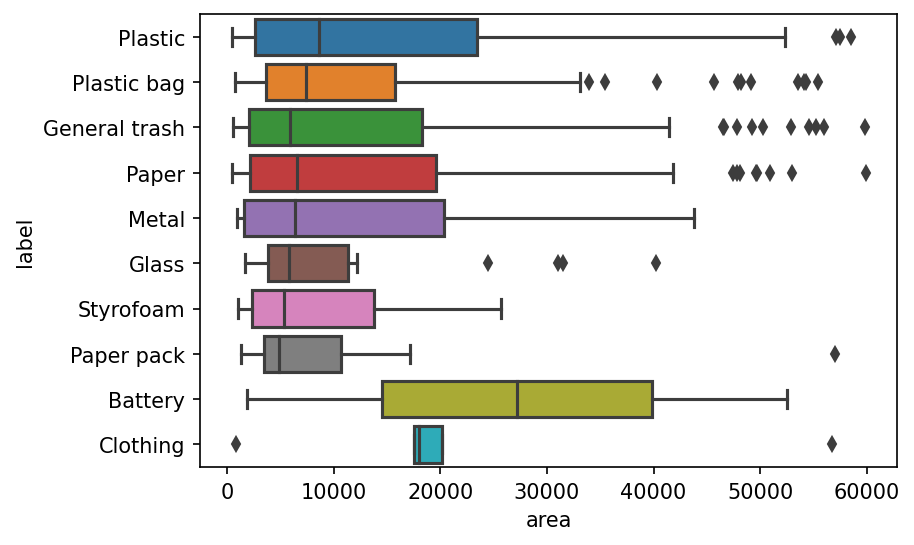

In [19]:
threshold = 60000
cut_result_df =  result_df[result_df['area']<threshold]
fig, ax = plt.subplots(1, 1, dpi = 150)
sns.boxplot(data=cut_result_df, x='area', y='label', dodge=True, ax=ax)
# 최대값을 0.1로 짜르자